In [32]:
import pandas as pd
import requests
import dotenv
import os
import json
from pathlib import Path
import numpy
from datetime import datetime
import dateutil.parser
import numpy as np

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [33]:
dotenv.load_dotenv()

True

In [34]:
start_date = '2018-01-20'

symbol = "CADUSD.FOREX"
asset = "CAD/USD"

eod_api_key = os.getenv("EOD_API_KEY")
eod_option = {'api_token': eod_api_key, 'order': 'd', 'fmt': 'json', 'from': start_date}
eod_option

{'api_token': '5fa212b3754234.49376057',
 'order': 'd',
 'fmt': 'json',
 'from': '2018-01-20'}

In [35]:
eod_request_url = "https://eodhistoricaldata.com/api/eod/" + symbol
#eod_request_url = "https://eodhistoricaldata.com/api/eod/MSFT.US?api_token=5fa212b3754234.49376057"
eod_request_url

'https://eodhistoricaldata.com/api/eod/CADUSD.FOREX'

### Execute GET request with API key

In [36]:
# Execute get request
eod_response_data = requests.get(eod_request_url, eod_option)
#response_content = eod_response_data.content
#print(response_content)
eod_data = eod_response_data.json()
#print(json.dumps(eod_data, indent=4))

In [37]:
column_list = ['date', 'Close']
eod_df = pd.DataFrame(columns=column_list)

for dict in eod_data: 
    for list in dict: 
        if list == "date":
            temp_date = datetime.strptime(dict[list], '%Y-%m-%d')
            #print(temp_date)
        elif list == "adjusted_close":
            temp_close = dict[list] 
            
    new_row = {'date':temp_date, 'Close':temp_close, 'Symbol':asset}
    eod_df = eod_df.append(new_row, ignore_index=True)                 
    
eod_df = eod_df.set_index(['date']) 
eod_df = eod_df.sort_index()
eod_df.head()

,Close,Symbol
date,,
2018-01-22,0.8036,CAD/USD
2018-01-23,0.8054,CAD/USD
2018-01-24,0.8098,CAD/USD
2018-01-25,0.8076,CAD/USD
2018-01-26,0.8123,CAD/USD


In [38]:
# Drop NAs and Calculate Daily Returns 

eod_df.columns = ['Close', 'Symbol']
eod_df['daily_return'] = eod_df['Close'].dropna().pct_change()
eod_df.head()

,Close,Symbol,daily_return
date,,,
2018-01-22,0.8036,CAD/USD,NaN
2018-01-23,0.8054,CAD/USD,0.002240
2018-01-24,0.8098,CAD/USD,0.005463
2018-01-25,0.8076,CAD/USD,-0.002717
2018-01-26,0.8123,CAD/USD,0.005820


### Construct Exponential Moving Average of Closing Prices (Trading Signal, Feature One)

In [39]:
# Set short and long windows
short_window = 1
long_window = 10

# Construct a `Fast` and `Slow` Exponential Moving Average from short and long windows, respectively
eod_df['fast_close'] = eod_df['Close'].ewm(halflife=short_window).mean()
eod_df['slow_close'] = eod_df['Close'].ewm(halflife=long_window).mean()

# Construct a crossover trading signal
eod_df['crossover_long'] = np.where(eod_df['fast_close'] > eod_df['slow_close'], 1.0, 0.0)
eod_df['crossover_short'] = np.where(eod_df['fast_close'] < eod_df['slow_close'], -1.0, 0.0)
eod_df['crossover_signal'] = eod_df['crossover_long'] + eod_df['crossover_short']

eod_df.head()

,Close,Symbol,daily_return,fast_close,slow_close,crossover_long,crossover_short,crossover_signal
date,,,,,,,,
2018-01-22,0.8036,CAD/USD,NaN,0.803600,0.803600,0.0,0.0,0.0
2018-01-23,0.8054,CAD/USD,0.002240,0.804800,0.804531,1.0,0.0,1.0
2018-01-24,0.8098,CAD/USD,0.005463,0.807657,0.806410,1.0,0.0,1.0
2018-01-25,0.8076,CAD/USD,-0.002717,0.807627,0.806739,1.0,0.0,1.0
2018-01-26,0.8123,CAD/USD,0.005820,0.810039,0.808011,1.0,0.0,1.0


### Plot Exponential Moving Average of Closing Prices

<AxesSubplot:xlabel='date'>

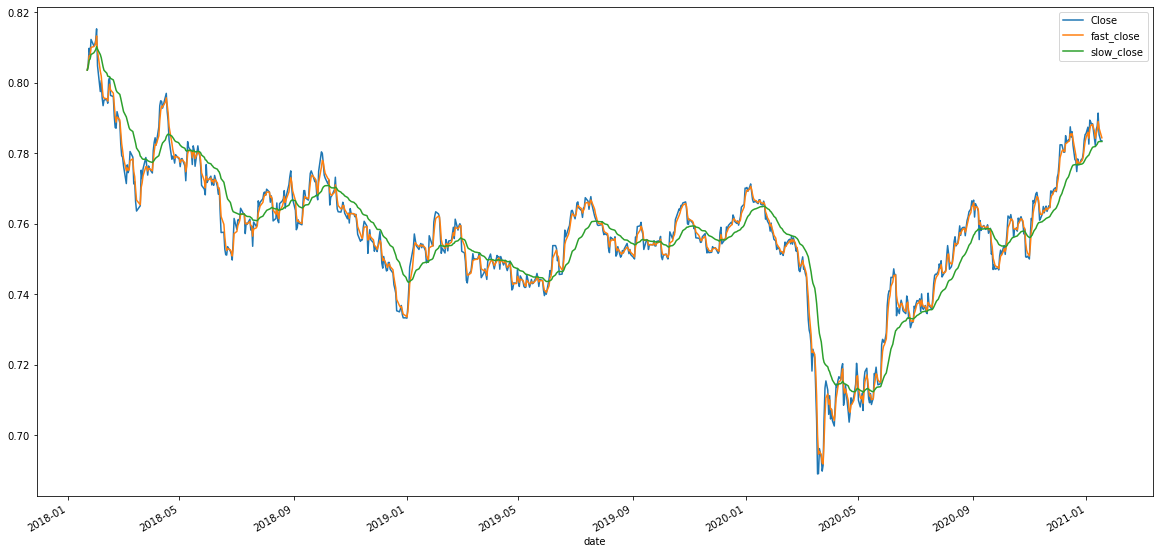

In [40]:
# Plot the EMA of CAD/USD closing prices
#!python -m pip install -U matplotlib

eod_df[['Close', 'fast_close', 'slow_close']].plot(figsize=(20,10))

### Construct Exponential Moving Average of Daily Return Volatility (Trading Signal, Feature Two)

In [63]:
# Set short and long volatility windows
short_vol_window = 1
long_vol_window = 10

# Construct a `Fast` and `Slow` Exponential Moving Average from short and long windows, respectively
eod_df['fast_vol'] = eod_df['daily_return'].ewm(halflife=short_vol_window).std()
eod_df['slow_vol'] = eod_df['daily_return'].ewm(halflife=long_vol_window).std()

# Construct a crossover trading signal
eod_df['vol_trend_long'] = np.where(eod_df['fast_vol'] < eod_df['slow_vol'], 1.0, 0.0)
eod_df['vol_trend_short'] = np.where(eod_df['fast_vol'] > eod_df['slow_vol'], -1.0, 0.0) 
eod_df['vol_trend_signal'] = eod_df['vol_trend_long'] + eod_df['vol_trend_short']

eod_df.head(20)

,Close,Symbol,daily_return,fast_close,slow_close,crossover_long,crossover_short,crossover_signal,fast_vol,slow_vol,...,vol_trend_short,vol_trend_signal,bollinger_mid_band,bollinger_std,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal,Positive Return
date,,,,,,,,,,,,,,,,,,,,,
2018-01-23,0.8054,CAD/USD,0.002240,0.804800,0.804531,1.0,0.0,1.0,NaN,NaN,...,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0
2018-01-24,0.8098,CAD/USD,0.005463,0.807657,0.806410,1.0,0.0,1.0,0.002279,0.002279,...,-1.0,-1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0
2018-01-25,0.8076,CAD/USD,-0.002717,0.807627,0.806739,1.0,0.0,1.0,0.004834,0.004199,...,-1.0,-1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
2018-01-26,0.8123,CAD/USD,0.005820,0.810039,0.808011,1.0,0.0,1.0,0.004699,0.004029,...,-1.0,-1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0
2018-01-29,0.8105,CAD/USD,-0.002216,0.810273,0.808501,1.0,0.0,1.0,0.004680,0.004140,...,-1.0,-1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
2018-01-30,0.8108,CAD/USD,0.000370,0.810539,0.808901,1.0,0.0,1.0,0.003255,0.003675,...,0.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0
2018-01-31,0.8120,CAD/USD,0.001480,0.811272,0.809389,1.0,0.0,1.0,0.002378,0.003294,...,0.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0
2018-02-01,0.8153,CAD/USD,0.004064,0.813290,0.810242,1.0,0.0,1.0,0.002543,0.003172,...,0.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0
2018-02-02,0.8048,CAD/USD,-0.012879,0.809041,0.809513,0.0,-1.0,-1.0,0.009602,0.006207,...,-1.0,-1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0


### Plot Exponential Moving Average of Daily Return Volatility

<AxesSubplot:xlabel='date'>

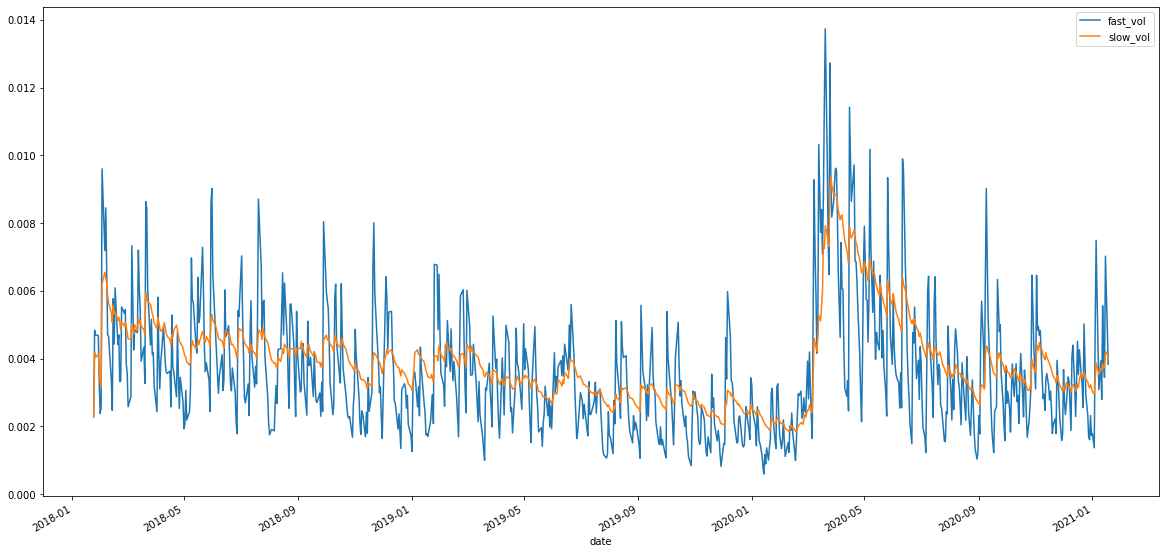

In [42]:
# Plot the EMA of CAD/USD daily return volatility
eod_df[['fast_vol', 'slow_vol']].plot(figsize=(20,10))

### Construct Bollinger Band (Trading Signal, Feature Three)

In [43]:
# Set bollinger band window
bollinger_window = 20

# Calculate rolling mean and standard deviation
eod_df['bollinger_mid_band'] = eod_df['Close'].rolling(window=bollinger_window).mean()
eod_df['bollinger_std'] = eod_df['Close'].rolling(window=20).std()

# Calculate upper and lowers bands of bollinger band
eod_df['bollinger_upper_band']  = eod_df['bollinger_mid_band'] + (eod_df['bollinger_std'] * 1)
eod_df['bollinger_lower_band']  = eod_df['bollinger_mid_band'] - (eod_df['bollinger_std'] * 1)

# Calculate bollinger band trading signal
eod_df['bollinger_long'] = np.where(eod_df['Close'] < eod_df['bollinger_lower_band'], 1.0, 0.0)
eod_df['bollinger_short'] = np.where(eod_df['Close'] > eod_df['bollinger_upper_band'], -1.0, 0.0)
eod_df['bollinger_signal'] = eod_df['bollinger_long'] + eod_df['bollinger_short']

eod_df.head()

,Close,Symbol,daily_return,fast_close,slow_close,crossover_long,crossover_short,crossover_signal,fast_vol,slow_vol,vol_trend_long,vol_trend_short,vol_trend_signal,bollinger_mid_band,bollinger_std,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal
date,,,,,,,,,,,,,,,,,,,,
2018-01-22,0.8036,CAD/USD,NaN,0.803600,0.803600,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2018-01-23,0.8054,CAD/USD,0.002240,0.804800,0.804531,1.0,0.0,1.0,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2018-01-24,0.8098,CAD/USD,0.005463,0.807657,0.806410,1.0,0.0,1.0,0.002279,0.002279,0.0,-1.0,-1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2018-01-25,0.8076,CAD/USD,-0.002717,0.807627,0.806739,1.0,0.0,1.0,0.004834,0.004199,0.0,-1.0,-1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2018-01-26,0.8123,CAD/USD,0.005820,0.810039,0.808011,1.0,0.0,1.0,0.004699,0.004029,0.0,-1.0,-1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0


### **Plot Bollinger Bands**

<AxesSubplot:xlabel='date'>

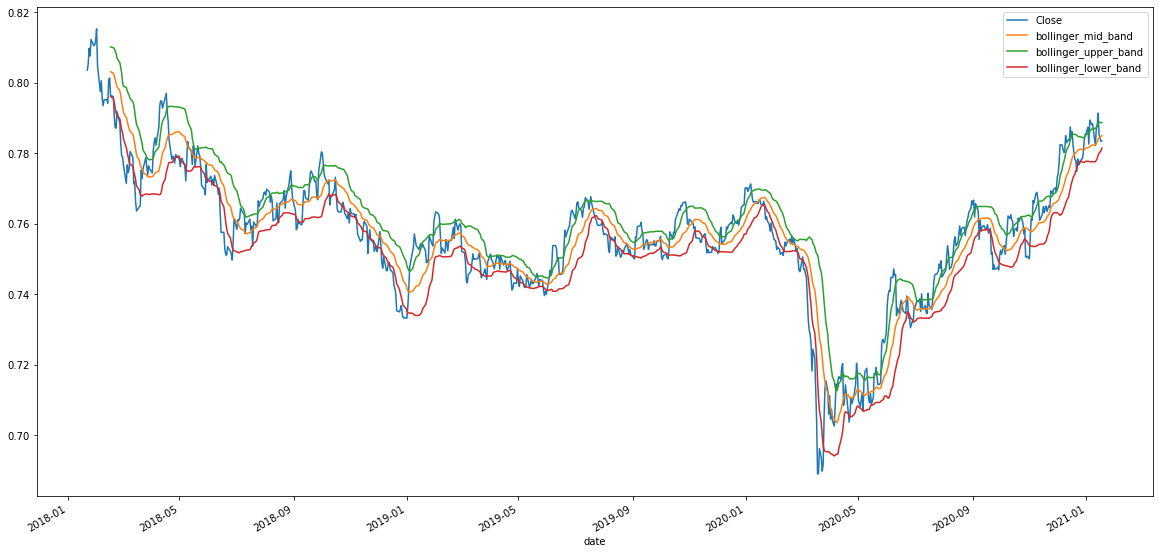

In [44]:
# Plot the Bollinger Bands for closing prices
eod_df[['Close','bollinger_mid_band','bollinger_upper_band','bollinger_lower_band']].plot(figsize=(20,10))

### Creating the Features `X` and Target `y` Data

The first step towards preparing the data is to create the input features vectors `X` and the target vector `y`. We will use the `window_data()` function to create these vectors.

This function chunks the data up with a rolling window of _X<sub>t</sub> - window_ to predict _X<sub>t</sub>_.

The function returns two `numpy` arrays:

* `X`: The input features vectors.

* `y`: The target vector.

The function has the following parameters:

* `eod_df`: The original DataFrame with the time series data.

* `window`: The window size in days of previous closing prices that will be used for the prediction.

* `feature_col_number`: The column number from the original DataFrame where the features are located.

* `target_col_number`: The column number from the original DataFrame where the target is located.

In [45]:
def window_data(df, window, feature_col_number, target_col_number):
    """
    This function accepts the column number for the features (X) and the target (y).
    It chunks the data up with a rolling window of Xt - window to predict Xt.
    It returns two numpy arrays of X and y.
    """
    X = []
    y = []
    for i in range(len(df) - window):
        features = df.iloc[i : (i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In the forthcoming activities, we will predict closing prices using a `10` days windows of previous CAD/USD closing prices, so that, we will create the `X` and `y` vectors by calling the `window_data` function and defining a window size of `10` and setting the features and target column numbers to `0` (this is the column with the CAD/USD closing prices).

In [46]:
# Creating the features (X) and target (y) data using the window_data() function.
window_size = 3

feature_column = 0
target_column = 0
X, y = window_data(eod_df, window_size, feature_column, target_column)
print (f"X sample values:\n{X[:15]} \n")
print (f"y sample values:\n{y[:15]}")

X sample values:
[[0.8036 0.8054 0.8098]
 [0.8054 0.8098 0.8076]
 [0.8098 0.8076 0.8123]
 [0.8076 0.8123 0.8105]
 [0.8123 0.8105 0.8108]
 [0.8105 0.8108 0.812 ]
 [0.8108 0.812  0.8153]
 [0.812  0.8153 0.8048]
 [0.8153 0.8048 0.7975]
 [0.8048 0.7975 0.8006]
 [0.7975 0.8006 0.7957]
 [0.8006 0.7957 0.7935]
 [0.7957 0.7935 0.7951]
 [0.7935 0.7951 0.7953]
 [0.7951 0.7953 0.7942]] 

y sample values:
[[0.8076]
 [0.8123]
 [0.8105]
 [0.8108]
 [0.812 ]
 [0.8153]
 [0.8048]
 [0.7975]
 [0.8006]
 [0.7957]
 [0.7935]
 [0.7951]
 [0.7953]
 [0.7942]
 [0.8007]]


### Drop NAs and Replace Infs (Positive/Negative Infinity) 

In [47]:
# Drop NAs and replace positive/negative infinity values
eod_df.dropna(subset=['daily_return', 'crossover_signal', 'vol_trend_signal', 'bollinger_signal'], inplace=True)
eod_df = eod_df.replace([np.inf, -np.inf], np.nan)
eod_df.head()

,Close,Symbol,daily_return,fast_close,slow_close,crossover_long,crossover_short,crossover_signal,fast_vol,slow_vol,vol_trend_long,vol_trend_short,vol_trend_signal,bollinger_mid_band,bollinger_std,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal
date,,,,,,,,,,,,,,,,,,,,
2018-01-23,0.8054,CAD/USD,0.002240,0.804800,0.804531,1.0,0.0,1.0,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2018-01-24,0.8098,CAD/USD,0.005463,0.807657,0.806410,1.0,0.0,1.0,0.002279,0.002279,0.0,-1.0,-1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2018-01-25,0.8076,CAD/USD,-0.002717,0.807627,0.806739,1.0,0.0,1.0,0.004834,0.004199,0.0,-1.0,-1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2018-01-26,0.8123,CAD/USD,0.005820,0.810039,0.808011,1.0,0.0,1.0,0.004699,0.004029,0.0,-1.0,-1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2018-01-29,0.8105,CAD/USD,-0.002216,0.810273,0.808501,1.0,0.0,1.0,0.004680,0.004140,0.0,-1.0,-1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0


### Construct the Dependent Variable

In [48]:
# Construct the dependent variable where if daily return is greater than 0, then 1, else, 0.
eod_df['Positive Return'] = np.where(eod_df['daily_return'] > 0, 1.0, 0.0)
eod_df

,Close,Symbol,daily_return,fast_close,slow_close,crossover_long,crossover_short,crossover_signal,fast_vol,slow_vol,...,vol_trend_short,vol_trend_signal,bollinger_mid_band,bollinger_std,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal,Positive Return
date,,,,,,,,,,,,,,,,,,,,,
2018-01-23,0.8054,CAD/USD,0.002240,0.804800,0.804531,1.0,0.0,1.0,NaN,NaN,...,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0
2018-01-24,0.8098,CAD/USD,0.005463,0.807657,0.806410,1.0,0.0,1.0,0.002279,0.002279,...,-1.0,-1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0
2018-01-25,0.8076,CAD/USD,-0.002717,0.807627,0.806739,1.0,0.0,1.0,0.004834,0.004199,...,-1.0,-1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
2018-01-26,0.8123,CAD/USD,0.005820,0.810039,0.808011,1.0,0.0,1.0,0.004699,0.004029,...,-1.0,-1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0
2018-01-29,0.8105,CAD/USD,-0.002216,0.810273,0.808501,1.0,0.0,1.0,0.004680,0.004140,...,-1.0,-1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
2018-01-30,0.8108,CAD/USD,0.000370,0.810539,0.808901,1.0,0.0,1.0,0.003255,0.003675,...,0.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0
2018-01-31,0.8120,CAD/USD,0.001480,0.811272,0.809389,1.0,0.0,1.0,0.002378,0.003294,...,0.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0
2018-02-01,0.8153,CAD/USD,0.004064,0.813290,0.810242,1.0,0.0,1.0,0.002543,0.003172,...,0.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0
2018-02-02,0.8048,CAD/USD,-0.012879,0.809041,0.809513,0.0,-1.0,-1.0,0.009602,0.006207,...,-1.0,-1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0


### Splitting Data Between Training and Testing Sets

To avoid the dataset being randomized, we will manually split the data using array slicing.

In [49]:
# Use 70% of the data for training and the remainder for testing
split = int(0.7 * len(X))
X_train = X[: split]
X_test = X[split:]
y_train = y[: split]
y_test = y[split:]

### Scaling Data with `MinMaxScaler`

Once the training and test datasets are created, we need to scale the data before training the LSTM model. We will use the `MinMaxScaler` from `sklearn` to scale all values between `0` and `1`.

Note that due to the CAD/USD data arange, we will skip the scaling both features and target sets.

In [50]:
# Use the MinMaxScaler to scale data between 0 and 1.
#from sklearn.preprocessing import MinMaxScaler

#scaler = MinMaxScaler()
#scaler.fit(X)
#X_train = scaler.transform(X_train)
#X_test = scaler.transform(X_test)
#scaler.fit(y)
#y_train = scaler.transform(y_train)
#y_test = scaler.transform(y_test)

### Reshape Features Data for the LSTM Model

The LSTM API from Keras needs to receive the features data as a _vertical vector_, so that we need to reshape the `X` data in the form `reshape((X_train.shape[0], X_train.shape[1], 1))`.

Both sets, training, and testing are reshaped.

In [51]:
# Reshape the features for the model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
print (f"X_train sample values:\n{X_train[:5]} \n")
print (f"X_test sample values:\n{X_test[:5]}")

X_train sample values:
[[[0.8036]
  [0.8054]
  [0.8098]]

 [[0.8054]
  [0.8098]
  [0.8076]]

 [[0.8098]
  [0.8076]
  [0.8123]]

 [[0.8076]
  [0.8123]
  [0.8105]]

 [[0.8123]
  [0.8105]
  [0.8108]]] 

X_test sample values:
[[[0.7128]
  [0.7059]
  [0.7112]]

 [[0.7059]
  [0.7112]
  [0.7046]]

 [[0.7112]
  [0.7046]
  [0.7074]]

 [[0.7046]
  [0.7074]
  [0.7041]]

 [[0.7074]
  [0.7041]
  [0.7026]]]


## Build and Train the LSTM RNN

In this section, we will design a custom LSTM RNN in Keras and fit (train) it using the training data we defined.

We will need to:

1. Define the model architecture in Keras.

2. Compile the model.

3. Fit the model to the training data.

### Importing the Keras Modules

The LSTM RNN model in Keras uses the `Sequential` model and the `LSTM` layer as we did before. However, there is a new type of layer called `Dropout`.

* `Dropout`: Dropout is a regularization technique for reducing overfitting in neural networks. This type of layer applies the dropout technique to the input.

In [52]:
# Import required Keras modules
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

### Defining the LSTM RNN Model Structure

To create an LSTM RNN model, we will add `LSTM` layers. The `return_sequences` parameter needs to set to `True` every time we add a new `LSTM` layer, excluding the final layer. The `input_shape` is the number of time steps and the number of indicators

After each `LSTM` layer, we add a `Dropout` layer to prevent overfitting. The parameter passed to the `Dropout` layer is the fraction of nodes that will be drop on each epoch, for this demo, we will use a dropout value of `0.2`, it means that on each epoch we will randomly drop `20%` of the units.

The number of units in each `LSTM` layers, is equal to the size of the time window, in this demo, we are taking five previous `T-Bons` closing price to predict the next closing price.

In [53]:
# Define the LSTM RNN model.
model = Sequential()

number_units = 10
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))
# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))
# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))
# Output layer
model.add(Dense(1))

### Compiling the LSTM RNN Model

We will compile the model, using the `adam` optimizer, as loss function, we will use `mean_square_error` since the value we want to predict is continuous.

In [54]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

In [55]:
# Summarize the model
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 3, 10)             480       
_________________________________________________________________
dropout_3 (Dropout)          (None, 3, 10)             0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 3, 10)             840       
_________________________________________________________________
dropout_4 (Dropout)          (None, 3, 10)             0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 10)                840       
_________________________________________________________________
dropout_5 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

### Training the Model

Once the model is defined, we train (fit) the model using `10` epochs. Since we are working with time-series data, it's important to set `shuffle=False` since it's necessary to keep the sequential order of the data.

We can experiment with the `batch_size` parameter; however, smaller batch size is recommended; in this demo, we will use a `batch_size=1`.

In [56]:
# Train the model
model.fit(X_train, y_train, epochs=10, shuffle=False, batch_size=1, verbose=1)

Epoch 1/10
583/583 [==============================] - 6s 4ms/step - loss: 0.1636
Epoch 2/10
583/583 [==============================] - 2s 3ms/step - loss: 0.0157
Epoch 3/10
583/583 [==============================] - 2s 3ms/step - loss: 0.0108
Epoch 4/10
583/583 [==============================] - 2s 3ms/step - loss: 0.0082
Epoch 5/10
583/583 [==============================] - 2s 4ms/step - loss: 0.0065
Epoch 6/10
583/583 [==============================] - 2s 4ms/step - loss: 0.0046
Epoch 7/10
583/583 [==============================] - 2s 3ms/step - loss: 0.0042
Epoch 8/10
583/583 [==============================] - 2s 3ms/step - loss: 0.0030
Epoch 9/10
583/583 [==============================] - 2s 4ms/step - loss: 0.0020
Epoch 10/10
583/583 [==============================] - 2s 4ms/step - loss: 0.0019


## Model Performance

In this section, we will evaluate the model using the test data. 

We will need to:

1. Evaluate the model using the `X_test` and `y_test` data.

2. Use the `X_test` data to make predictions.

3. Create a DataFrame of real (`y_test`) vs predicted values.

4. Plot the Real vs predicted values as a line chart.

### Evaluate the Model

It's time to evaluate our model to assess its performance. We will use the `evaluate` method using the testing data.

In [57]:
# Evaluate the model
model.evaluate(X_test, y_test)

8/8 [==============================] - 1s 2ms/step - loss: 0.0022


0.0021845183800905943

### Making Predictions

We will make some closing price predictions using our brand new LSTM RNN model and our testing data.

In [58]:
# Make some predictions
predicted = model.predict(X_test)

Since we did not scale the original values using the `MinMaxScaler`, we don't need to recover the original prices to better understand the predictions.

We will skip using the `inverse_transform()` method of the scaler to decode the scaled values to their original scale.

In [59]:
# Recover the original prices instead of the scaled version
#predicted_prices = scaler.inverse_transform(predicted)
predicted_prices = predicted

#real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))
real_prices = y_test

### Plotting Predicted Vs. Real Prices

To plot the predicted vs. the real values, we will create a DataFrame.

In [60]:
# Create a DataFrame of Real and Predicted values
exchange_rate = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
    }, index = eod_df.index[-len(real_prices): ])

exchange_rate.head()

,Real,Predicted
date,,
2020-04-01,0.7046,0.708394
2020-04-02,0.7074,0.708378
2020-04-03,0.7041,0.708382
2020-04-05,0.7026,0.708365
2020-04-06,0.7087,0.708364


<AxesSubplot:xlabel='date'>

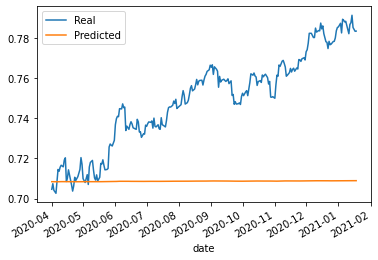

In [61]:
# Plot the real vs predicted prices as a line chart
exchange_rate.plot()

In [62]:
n_kw_list = ["castor","coconut", "cotton", "groundnut", "lin", "palm", "rape", "soy","sun", "veg", "vegetable" ]
kw_list = ["crude","oil"]